# Google Colab - Numba GPU

Verifica se a GPU está configurada e funcionando:

In [1]:
from numba import cuda
print(cuda.gpus)

<Managed Device 0>


In [2]:
! nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-fb13b8fb-38d9-a395-5692-6487294a4625)


In [3]:
! nvidia-smi

Thu Oct  7 22:26:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
def stencil(n) :
    import numpy as np, math
    from time import time
    from numba import cuda

    # parameters
    # n            = 2400    # nxn grid <-- parameter passing
    energy       = 1       # energy to be injected per iteration
    niters       = 250     # number of iterations
    # initialize the data arrays
    anew         = np.zeros((n + 2, n + 2), np.float64)
    aold         = np.zeros((n + 2, n + 2), np.float64)
    # initialize three heat sources
    sources      = np.empty((3, 2), np.int32)
    sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

    # configure blocks & grids
    ## set the number of threads in a block
    threads_per_block = (16, 16)
    ## calculate the number of thread blocks in the grid
    blocks_per_grid_x = math.ceil(aold.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(aold.shape[1] / threads_per_block[1])
    blocks_per_grid   = (blocks_per_grid_x, blocks_per_grid_y)

    # computationally intensive core
    @cuda.jit
    def kernel(A, B, sources, energy):
        n = A.shape[0] - 1
        i, j = cuda.grid(2)
        if (i > 0 and j > 0) and (i < n and j < n) :
            A[i,j]=.5*B[i,j]+.125*(B[i-1,j]+B[i+1,j]+B[i,j-1]+B[i,j+1])
            if ((sources[0, 0] == i and sources[0, 1] == j) or
                (sources[1, 0] == i and sources[1, 1] == j) or
                (sources[2, 0] == i and sources[2, 1] == j)):
                A[i, j] += energy

    # main routine
    t0 = -time()    # time measure
    t1 = 0
    t2 = 0

    t_ = time()
    # copy the arrays to the device
    anew_global_mem    = cuda.to_device(anew)
    aold_global_mem    = cuda.to_device(aold)
    sources_global_mem = cuda.to_device(sources)
    t2 += time() - t_

    for _ in range(0, niters, 2) :
        t_ = time()
        kernel[blocks_per_grid, threads_per_block](
            anew_global_mem, aold_global_mem, sources_global_mem, energy)
        kernel[blocks_per_grid, threads_per_block](
            aold_global_mem, anew_global_mem, sources_global_mem, energy)
        t1 += time() - t_

    t_ = time()
    # copy the result back to the host
    aold = aold_global_mem.copy_to_host()
    t2 += time() - t_

    # system total heat
    heat = np.sum(aold[1:-1, 1:-1])

    t0 += time()

    # show the result
    print(f"Heat: {heat:.4f}", end=" | ")
    print(f"Time: {t0:.4f} s", end=" | ")
    print(f"Kernel: {t1:.4f} s", end=" | ")
    print(f"Memory: {t2:.4f} s")
    
    return aold

aold = stencil(2400)

Heat: 750.0000 | Time: 1.4714 s | Kernel: 0.4834 s | Memory: 0.9804 s


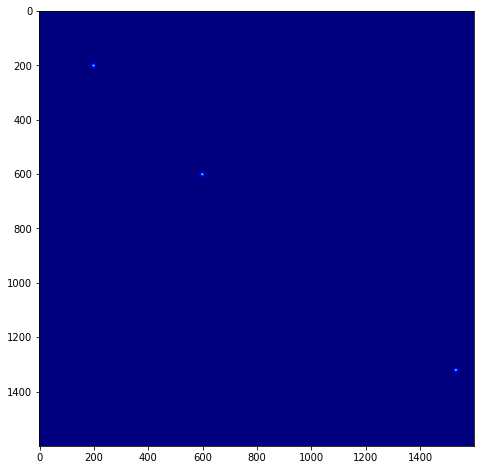

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold[600:2200,600:2200], cmap='jet')

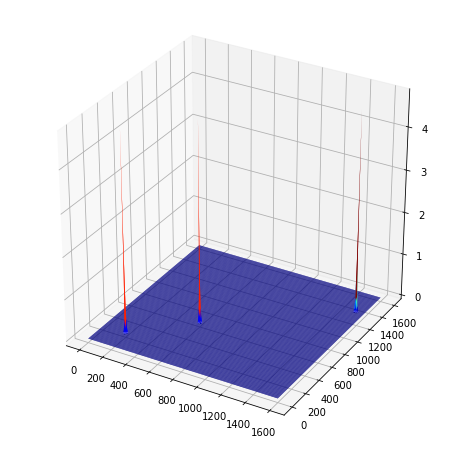

In [12]:
a    = aold[600:2200,600:2200]
t    = np.arange(a.shape[0])
x, y = np.meshgrid(t, t)
ax = plt.figure(figsize=(8, 8)).gca(projection='3d')
ax.plot_surface(x, y, a, cmap='jet', rcount=200, ccount=200)
plt.show()

---

# Usando uma grade com 8 x 8 pontos

In [13]:
aold = stencil(8)

Heat: 102.6641 | Time: 0.4029 s | Kernel: 0.3996 s | Memory: 0.0032 s


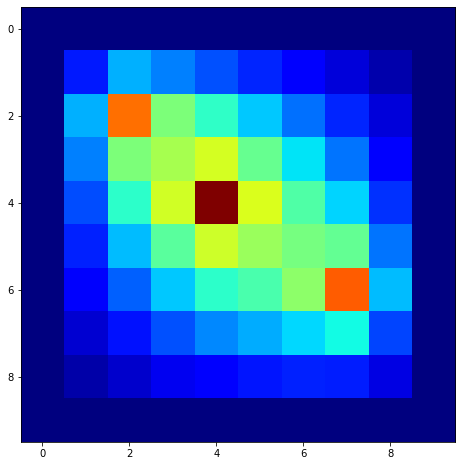

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold, cmap='jet')

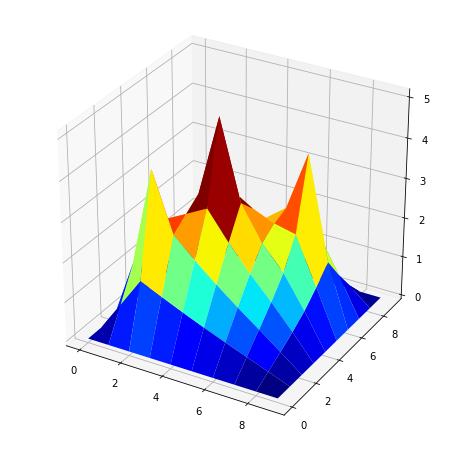

In [15]:
t    = np.arange(aold.shape[0])
x, y = np.meshgrid(t, t)
ax = plt.figure(figsize=(8, 8)).gca(projection='3d')
ax.plot_surface(x, y, aold, cmap='jet')
plt.show()

---

# Grade 24 x 24

In [16]:
aold = stencil(24)

Heat: 512.0860 | Time: 0.4067 s | Kernel: 0.4044 s | Memory: 0.0021 s


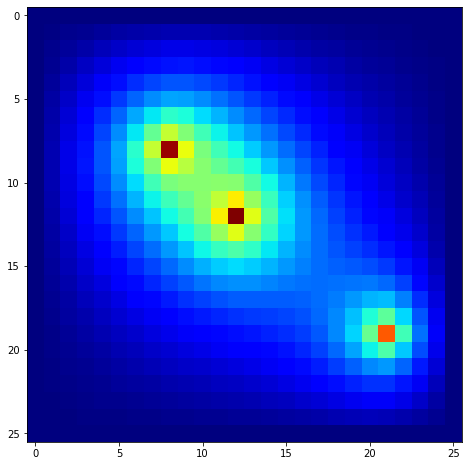

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold, cmap='jet')

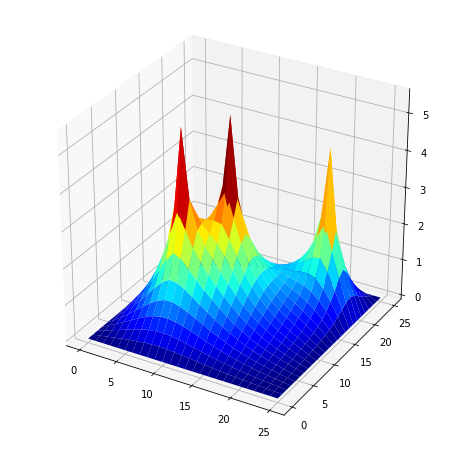

In [18]:
t    = np.arange(aold.shape[0])
x, y = np.meshgrid(t, t)
ax = plt.figure(figsize=(8, 8)).gca(projection='3d')
ax.plot_surface(x, y, aold, cmap='jet')
plt.show()

---

# Grade 240 x 240

In [19]:
aold = stencil(240)

Heat: 749.9878 | Time: 0.4113 s | Kernel: 0.4076 s | Memory: 0.0033 s


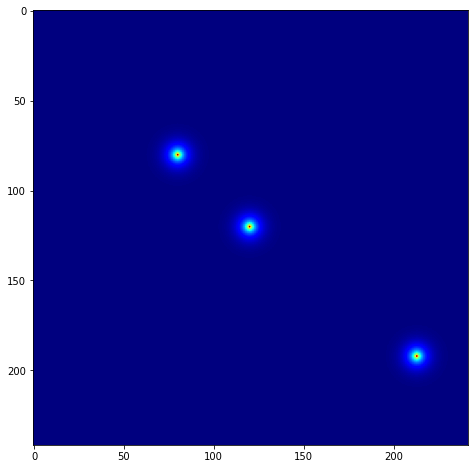

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold, cmap='jet')

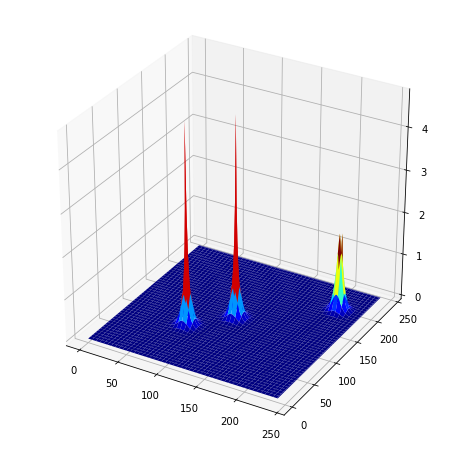

In [21]:
t    = np.arange(aold.shape[0])
x, y = np.meshgrid(t, t)
ax = plt.figure(figsize=(8, 8)).gca(projection='3d')
ax.plot_surface(x, y, aold, cmap='jet')
plt.show()